# Tesseract Evaluation - matched lines

Dieses Notebook untersucht die Ausgabequalität des extrahierten Textes. Dazu werden alle Zeilen, die nicht von Tesseract erkannt wurden, ignoriert.  
Die Erkennungsrate zeigt dabei wieder wieviel des im Bild vorhandenen Textes, bzw. der vorhandenen Zeilen tatsächlich erkannt wurden.


---

### WER und CER in Bezug auf erkannte "Text-Zeilen" im Bild untersuchen
Um die Qualität der Texterkennung auf erkanntem Text im Bild zu bewerten, wird auch die Anzahl der erkannten Zeilen betrachtet.   
Wenn Zeilen gar nicht erkannt wurden, also betimmte Textbereiche im Bild nicht "gesehen" wurden, dann sinkt automatisch CER und WER.  
Nachfolgend soll nur CER und WER für die erkannten Zeilen berechnet werden

In [1]:
import os
import json
import pandas as pd

import sys # ermöglicht Zugriff auf übergeordnetes Verzeichnis
sys.path.append(os.path.abspath("../../utils"))
from funktionen import extract_ocr_lines, cer_for_matching, match_gt_to_ocr, calculate_char_accuracy, calculate_word_accuracy, calculate_wer,calculate_cer, CER_THRESHOLD 


# === Konfiguration ===
IMG_DIR = "../../data/images/insta_images"
JSON_PATH = "../../data/data_annotated.json"



# === Hauptprozess ===

with open(JSON_PATH, "r", encoding="utf-8") as f:
    all_data = json.load(f)

ergebnisse = []

for eintrag in all_data:
    file_name = eintrag.get("file_name")
    if not file_name:
        continue

    gt_lines = eintrag.get("lines", [])
    img_path = os.path.join(IMG_DIR, file_name)
    if not os.path.exists(img_path):
        continue

    ocr_lines = extract_ocr_lines(img_path)
    matches = match_gt_to_ocr(gt_lines, ocr_lines, CER_THRESHOLD)

    total_gt = len(gt_lines)
    total_ocr = len(ocr_lines)
    total_matches = 0

    matched_cer = []
    matched_wer = []
    matched_char_acc = []
    matched_word_acc = []

    for gt_idx, ocr_idx in matches:
        gt_line = gt_lines[gt_idx]
        if ocr_idx is not None:
            ocr_line = ocr_lines[ocr_idx]
            cer_score = calculate_cer(gt_line, ocr_line)
            wer_score = calculate_wer(gt_line, ocr_line)
            char_acc = calculate_char_accuracy(gt_line, ocr_line)
            word_acc = calculate_word_accuracy(gt_line, ocr_line)

            matched_cer.append(cer_score)
            matched_wer.append(wer_score)
            matched_char_acc.append(char_acc)
            matched_word_acc.append(word_acc)

            total_matches += 1

    ergebnisse.append({
        "file_name": file_name,
        "gt_lines": total_gt,
        "ocr_lines": total_ocr,
        "matched_lines": total_matches,
        "mean_cer": sum(matched_cer) / total_matches if total_matches else None,
        "mean_wer": sum(matched_wer) / total_matches if total_matches else None,
        "mean_char_acc": sum(matched_char_acc) / total_matches if total_matches else None,
        "mean_word_acc": sum(matched_word_acc) / total_matches if total_matches else None
    })


df_results = pd.DataFrame(ergebnisse)
display(df_results)

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc
0,0001.jpg,6,8,4,0.027778,0.125000,0.985294,1.000000
1,0002.jpg,7,5,3,0.000000,0.000000,1.000000,1.000000
2,0003.jpg,11,16,5,0.096985,0.166667,0.911020,0.600000
3,0004.jpg,11,5,1,0.379310,1.000000,0.653846,0.000000
4,0006.jpg,8,4,2,0.160000,0.166667,0.825000,0.500000
...,...,...,...,...,...,...,...,...
195,0238.jpg,13,16,4,0.270058,0.983333,0.750971,0.000000
196,0239.jpg,11,1,0,NaN,NaN,NaN,NaN
197,0240.jpg,10,10,10,0.014345,0.116667,0.995833,0.816667
198,0241.jpg,17,38,1,0.021739,0.200000,0.976190,0.800000


#### Bilder bei denen OCR und Ground Truth nicht gematcht werden konnten

In [2]:
# images bei denen keine passende Zeilen gefunden wurden / kein Match
df_results[df_results['matched_lines'] == 0]

,file_name,gt_lines,ocr_lines,matched_lines,mean_cer,mean_wer,mean_char_acc,mean_word_acc
5,0007.jpg,6,1,0,NaN,NaN,NaN,NaN
6,0009.jpg,15,3,0,NaN,NaN,NaN,NaN
8,0011.jpg,7,11,0,NaN,NaN,NaN,NaN
11,0014.jpg,8,1,0,NaN,NaN,NaN,NaN
21,0025.jpg,9,1,0,NaN,NaN,NaN,NaN
22,0026.jpg,6,1,0,NaN,NaN,NaN,NaN
23,0027.jpg,5,1,0,NaN,NaN,NaN,NaN
28,0032.jpg,8,4,0,NaN,NaN,NaN,NaN
30,0036.jpg,11,1,0,NaN,NaN,NaN,NaN
31,0037.jpeg,8,1,0,NaN,NaN,NaN,NaN


In [3]:
df_results[df_results['matched_lines'] == 0].shape[0]


39

In [4]:
(df_results['matched_lines'] == 0).mean()


0.195

---> bei 19.5 % der Bilder wurden keine Zeilen des OCR Outputs gefunden, die mit dem ground truth gematcht werden konnten

In [5]:
df_results["recognition_rate"] = df_results["matched_lines"] / df_results["gt_lines"]

In [14]:
df_results.to_csv("../../data/OCR/tesseract/tesseract_results_matched_lines_psm3.csv", index=False)

In [10]:
# Durchschnitt berechnen
mean_cer = df_results["mean_cer"].mean()
mean_wer = df_results["mean_wer"].mean()
mean_ER = df_results["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")

Durchschnittswerte ganzer Datensatz:
Erkennungsrate: 0.420
CER: 0.107
WER: 0.389


##### ---> Ergebnisse mit Einbeziehung der nicht erkannten Zeilen:   
Durchschnittswerte ganzer Datensatz:    
    Erkennungsrate: 0.420  
    CER: 0.617  
    WER: 0.717  

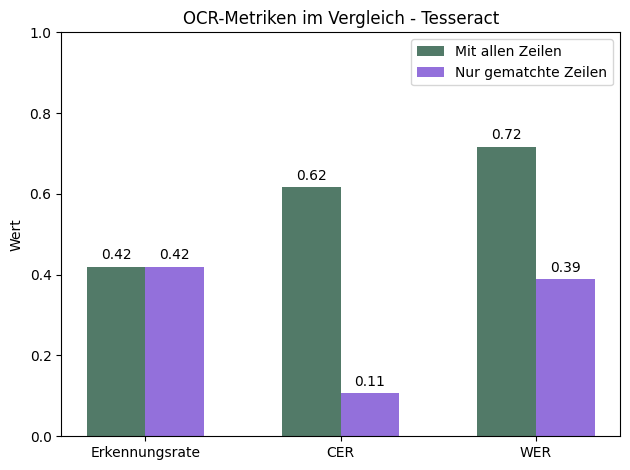

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Daten
werte = ['Erkennungsrate', 'CER', 'WER']
values_all = [0.420, 0.617, 0.717]  # mit nicht erkannten Zeilen
values_matched = [0.420, 0.107, 0.389]  # nur gematchte Zeilen

x = np.arange(len(werte))
width = 0.30

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, values_all, width, label='Mit allen Zeilen', color='#527a68')
bars2 = ax.bar(x + width/2, values_matched, width, label='Nur gematchte Zeilen', color='mediumpurple')


# Beschriftung
ax.set_ylabel('Wert')
ax.set_title('OCR-Metriken im Vergleich - Tesseract')
ax.set_xticks(x)
ax.set_xticklabels(werte)
ax.legend()
ax.set_ylim(0, 1)

# Werte anzeigen
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [11]:
df = pd.read_csv("../../data/OCR/tesseract_results_matched_lines_psm3.csv")

---

#### Berechnung CER/WER/Erkennungsrate ohne Einbeziehung der Images bei denen keine Zuordnung von OCR und Ground Truth möglich war

In [12]:

matches = df[df['matched_lines'] != 0]

# Durchschnitt berechnen
mean_cer = matches["mean_cer"].mean()
mean_wer = matches["mean_wer"].mean()
mean_ER = matches["recognition_rate"].mean()

# Ausgabe
print(f"Durchschnittswerte ganzer Datensatz / ohne NAN Werte:")
print(f"Erkennungsrate: {mean_ER:.3f}")
print(f"CER: {mean_cer:.3f}")
print(f"WER: {mean_wer:.3f}")


Durchschnittswerte ganzer Datensatz / ohne NAN Werte:
Erkennungsrate: 0.522
CER: 0.107
WER: 0.389


---> Erkennungsrate ging nach oben, weil Bilder, wo keine zuordnng von OCR und GT-Zeilen stattfand  ausgschlossen wuren aus Berechnung.